In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate 
import pandas as pd
%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (10,10)

We will use the PhotoZDC1 package, specifically photErrorModel, to create the errors, you can grab this package from GitHub with:<br>
git clone https://github.com/LSSTDESC/PhotoZDC1.git <br>
then add the location to your path, as below.  This implements the error model as defined in Ivezic et al (2008) (see: https://arxiv.org/abs/0805.2366 for details)

In [3]:
#Add the PhotoZDC1 package to the path and import photErrorModel that will be used to generate errors 
sys.path.insert(0, '/global/u2/s/schmidt9/PhotoZDC1/src')
import photErrorModel as errMod

Set up the LSST Error Model parameters.  Alex used some defaults from the Science Book that are not quite the same as the newest numbers from the Science Drivers document (arxiv: 0805.2366v5), so update them here.  We'll use the following number of total visits in 10 years as listed in Table 1:
NVISITS: u: 56  g: 80  r: 184  i: 184  z: 160  y: 160

And check the error model parameters against those listed in Table 2:
Nearly all values will have to be updated

Note that we should use ''theta_eff'', not ''theta'' in the tables!

There is a simple parameter to try to account for extended objects versus the point sources that these models are meant to approximate.  A quick discussion with Zeljko Ivezic and Andy Connolly years ago I believe decided on an offset in m5 value of 0.1 as a very rough approximation, so we'll add that with the errmodel.extendedsource = 0.1 parameter

We can check the param settings with the .\_\_repr\_\_ method

In [4]:
errmodel = errMod.LSSTErrorModel()
errmodel.tvis = 30.0
errmodel.nYrObs=10.0
visits = {'LSST_u':5.6, 'LSST_g':8.0, 'LSST_r':18.4, 'LSST_i':18.4,'LSST_z':16.0,'LSST_y':16.0}
errmodel.nVisYr=visits
msky = {'LSST_u':22.99, 'LSST_g':22.26, 'LSST_r':21.20, 'LSST_i':20.48,'LSST_z':19.60,
        'LSST_y':18.61}
errmodel.msky = msky
#theta = {'LSST_u':0.81, 'LSST_g':0.77, 'LSST_r':0.73, 'LSST_i':0.71,'LSST_z':0.69,'LSST_y':0.68}
theta = {'LSST_u':0.92, 'LSST_g':0.87, 'LSST_r':0.83, 'LSST_i':0.80,'LSST_z':0.78,'LSST_y':0.76}
errmodel.theta = theta
gamma = {'LSST_u':0.038, 'LSST_g':0.039, 'LSST_r':0.039, 'LSST_i':0.039,'LSST_z':0.039,
         'LSST_y':0.039}
errmodel.gamma = gamma
#cm = {'LSST_u':23.09, 'LSST_g':24.42, 'LSST_r':24.44, 'LSST_i':24.32,'LSST_z':24.16,'LSST_y':23.73}
cmshift = {'LSST_u':22.47, 'LSST_g':24.24, 'LSST_r':24.34, 'LSST_i':24.25,'LSST_z':24.11,
           'LSST_y':23.69}
errmodel.Cm = cmshift
km = {'LSST_u':0.491, 'LSST_g':0.213, 'LSST_r':0.126, 'LSST_i':0.096,'LSST_z':0.069,'LSST_y':0.170}
errmodel.km = km
errmodel.airMass = 1.2
errmodel.extendedSource=0.1
errmodel.sigmaSys = 0.005
errmodel.__repr__

<bound method LSSTErrorModel.__repr__ of 
 LSSTErrorModel parameters:
 Exposure time = 30.0 s
 Number of years of observations = 10.0
 Number of visits per year per band: {'LSST_u': 5.6, 'LSST_g': 8.0, 'LSST_r': 18.4, 'LSST_i': 18.4, 'LSST_z': 16.0, 'LSST_y': 16.0}
 Systematic error = 0.005 mag
 Airmass = 1.2
 Sky brightness per band: {'LSST_u': 22.99, 'LSST_g': 22.26, 'LSST_r': 21.2, 'LSST_i': 20.48, 'LSST_z': 19.6, 'LSST_y': 18.61} (mag)
 Seeing per band: {'LSST_u': 0.92, 'LSST_g': 0.87, 'LSST_r': 0.83, 'LSST_i': 0.8, 'LSST_z': 0.78, 'LSST_y': 0.76} (arcsec)
 gamma per band: {'LSST_u': 0.038, 'LSST_g': 0.039, 'LSST_r': 0.039, 'LSST_i': 0.039, 'LSST_z': 0.039, 'LSST_y': 0.039}
 Cm per band: {'LSST_u': 22.47, 'LSST_g': 24.24, 'LSST_r': 24.34, 'LSST_i': 24.25, 'LSST_z': 24.11, 'LSST_y': 23.69}
 Extinction coeff. per band: {'LSST_u': 0.491, 'LSST_g': 0.213, 'LSST_r': 0.126, 'LSST_i': 0.096, 'LSST_z': 0.069, 'LSST_y': 0.17}
 Extended source model: add 0.1 mag to 5-sigma depth for point so

Let's check the 5 sigma point source depths, which should equal the following numbers at Zenith (we need to account for the Delta_Cm values which account for instrumental noise, listed below are m5 values minus the deltaCm^inf values in Table 2 of the Ivezic paper)<br>
u: 23.78 - 0.62 = 23.16<br>
g: 24.81 - 0.18 = 24.63<br>
r: 24.35 - 0.10 = 24.25<br>
i: 23.92 - 0.07 = 23.85<br>
z: 23.34 - 0.05 = 23.29<br>
y: 22.45 - 0.04 = 22.41<br>

In [5]:
filts = ('LSST_u','LSST_g','LSST_r','LSST_i','LSST_z','LSST_y')
for filt in filts:
    print ("%s  %.2f"%(filt,errmodel._m5PointSources(cmshift[filt],msky[filt],theta[filt],30.,
                                                     km[filt],1.0)))
    #args are Cm, msky, theta, tvis (30 seconds), km, and X (airmass, set to zenith so 1.0)

LSST_u  23.17
LSST_g  24.63
LSST_r  24.26
LSST_i  23.85
LSST_z  23.29
LSST_y  22.41


m5 values check out to the .01 level, so that is good!<br>
Now let's import the catalog that we want, in this instance proto-dc2_v5.0

In [6]:
import GCRCatalogs
## check version
print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

GCRCatalogs = 0.8.0 | GCR = 0.7.2


In [7]:
#print('\n'.join(sorted(GCRCatalogs.get_available_catalogs(False))))

In [8]:
gc = GCRCatalogs.load_catalog('proto-dc2_v5.0_test')

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


In [9]:
#List all available quantities in the catalog
#print('\n'.join(sorted(gc.list_all_native_quantities())[:]))

Set up some names that we will use to grab the six LSST magnitudes from the catalog reader

In [10]:
filts = ('u','g','r','i','z','y')
magcols = []
pdcols = []
for filt in filts:
    magcols.append('LSST_filters/magnitude:LSST_%s:observed:dustAtlas'%filt)
    pdcols.append('LSST_%s_true'%filt)
allcols = magcols
allcols.append('redshift')
print (filts,magcols)

('u', 'g', 'r', 'i', 'z', 'y') ['LSST_filters/magnitude:LSST_u:observed:dustAtlas', 'LSST_filters/magnitude:LSST_g:observed:dustAtlas', 'LSST_filters/magnitude:LSST_r:observed:dustAtlas', 'LSST_filters/magnitude:LSST_i:observed:dustAtlas', 'LSST_filters/magnitude:LSST_z:observed:dustAtlas', 'LSST_filters/magnitude:LSST_y:observed:dustAtlas', 'redshift']


We will be computing the model errors for our mock galaxies.  The error fuction produced by the PZDC1.getMagError function is very smooth.  Rather than computing this for every galaxy, we will compute a grid for each filter and interpolate between them to speed up the computation.  We will set an ad hoc upper limit of 35 for magnitude, above this magnitude we will set the spline to return 99.0.  This should only really occur for flux <= 0.0 and a NaN in the log(flux).

In [11]:
mag_min = 10.
mag_max = 35.
num_gridpts = 4001 #parameters for magerr_spline
mag_grid = np.linspace(mag_min,mag_max,num_gridpts)
#print (mag_grid)

Now, define the functions for making the spline and creating new magnitudes.  For scattermag, we need to convert to flux, add Gaussian uncertainty, then convert back to flux.

In [12]:
def makespline(grid,filter):
    fx =  [errmodel.getMagError(x,filter) for x in grid]
    return fx

In [13]:
floor = 1.e-18
def scattermag(mag,magerr):
    """Add proper uncertainty to magnitude
    Parmeters
    ---------
    mag: 'float' array-like
        true magnitudes 
    magerr: 'float' array-like
        magnitude uncertainties 
    Returns
    -------
    newmag: 'float' array-like
        magnitudes with proper uncertainty, or 99 if flux was negative after error added
    """
    flux = [np.power(10.,-0.4*magx) for magx in mag]
#    errflux = np.array([fluxx*0.921034*magerrx for fluxx,magerrx in zip(flux,magerr)])
    errflux = np.array([fluxx*0.4*np.log(10.)*magerrx for fluxx,magerrx in zip(flux,magerr)])
    mask = (errflux<0.0)
    #print ("number with err < 0:%d\n"%(np.sum(mask)))
    errflux[mask] = 0.005
    tmperr = [np.random.normal(0.0,errfluxx) for errfluxx in errflux]
    newflux = np.subtract(flux,tmperr)
    mask = (newflux < floor)
    newflux[mask] = floor
    newmag = [-2.5*np.log10(newfluxx) for newfluxx in newflux]
    mask2 = (newmag != newmag)#error for NaN or Inf, which can happen if flux is negative or 0
    newmag[mask2] = 99.0
    return newmag

In [14]:
#shortfilts = (['g'])
#shortmags = (['LSST_filters/magnitude:LSST_g:observed:dustAtlas'])

Read in the data, create a Pandas dataframe for the true magnitudes, and add new columns for the magnitude errors.  Use the return_iterator=True option with the catalog reader to help handle the large data files

In [15]:
%%time
#alldata = []
#for data in gc.get_quantities(allcols,return_iterator=True, filters =['mag_i < 23.0','redshift < 3.0'] ): #include filters for small subset during testing
#for data in gc.get_quantities(allcols,return_iterator=True): #use the iterator method
#data = gc.get_quantities(allcols,filters = ['mag_i < 20.3','redshift < 3.0'])
data = gc.get_quantities(allcols)
df = pd.DataFrame(data, columns = allcols)
#df.rename(columns=colrename)
for filt,magcol in zip(filts,magcols):
    print ("working on filter %s"%(filt))
    tmpmag = data[magcol]
    grid_errs = makespline(mag_grid,'LSST_%s'%filt)
    #print (grid_errs)
    errspline = scipy.interpolate.interp1d(mag_grid,grid_errs,kind='linear',bounds_error=False,
                                           fill_value=99.0)#return 99.0 outside interval
    newerrx = [errspline(xmag) for xmag in tmpmag]
    newmag = np.array(scattermag(tmpmag,newerrx),dtype=np.float32)
    newerr = np.array([errspline(xmag) for xmag in newmag],dtype=np.float32)
    magname = 'scatmag_%s'%filt
    errname = 'scaterr_%s'%filt
    df[magname] = newmag
    df[errname] = newerr
#    pd.to_numeric(df[magname],downcast='float32')
    #alldata.append(tmpdf)


working on filter u
working on filter g
working on filter r
working on filter i
working on filter z
working on filter y
CPU times: user 1h 17min 23s, sys: 53.8 s, total: 1h 18min 17s
Wall time: 1h 18min 14s


In [16]:
#df = pd.concat(alldata)

Take a look at the dataframe

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18286706 entries, 0 to 18286705
Data columns (total 19 columns):
LSST_filters/magnitude:LSST_u:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_g:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_r:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_i:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_z:observed:dustAtlas    float32
LSST_filters/magnitude:LSST_y:observed:dustAtlas    float32
redshift                                            float64
scatmag_u                                           float32
scaterr_u                                           float32
scatmag_g                                           float32
scaterr_g                                           float32
scatmag_r                                           float32
scaterr_r                                           float32
scatmag_i                                           float32
scaterr_i                                    

In [18]:
utrue = df['LSST_filters/magnitude:LSST_u:observed:dustAtlas']
gtrue = df['LSST_filters/magnitude:LSST_g:observed:dustAtlas']
rtrue = df['LSST_filters/magnitude:LSST_r:observed:dustAtlas']
itrue = df['LSST_filters/magnitude:LSST_i:observed:dustAtlas']
ztrue = df['LSST_filters/magnitude:LSST_z:observed:dustAtlas']
ytrue = df['LSST_filters/magnitude:LSST_y:observed:dustAtlas']

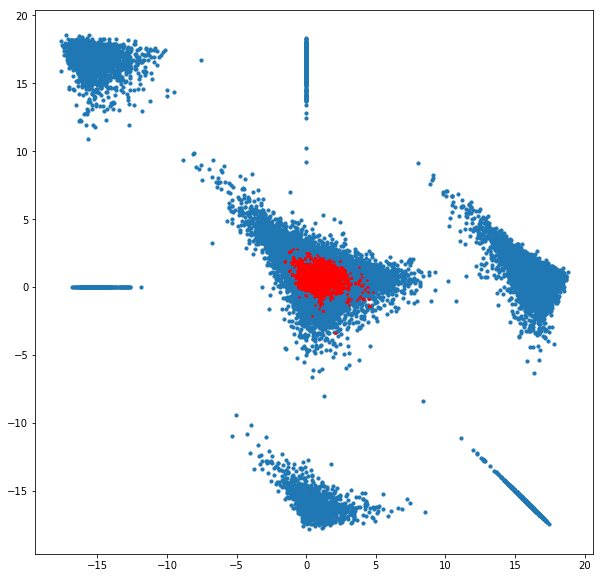

In [19]:
fig = plt.figure(figsize=(10,10))
plt.scatter(df['scatmag_g'][::100]-df['scatmag_r'][::100],
            df['scatmag_r'][::100]-df['scatmag_i'][::100],
            marker='o',s=10)
plt.scatter(gtrue-rtrue,rtrue-itrue,marker='o',s=2,c='r')
#plt.xlim([-.5,2.5])
#plt.ylim([-1.05,2.05])

(-0.001, 0.045)

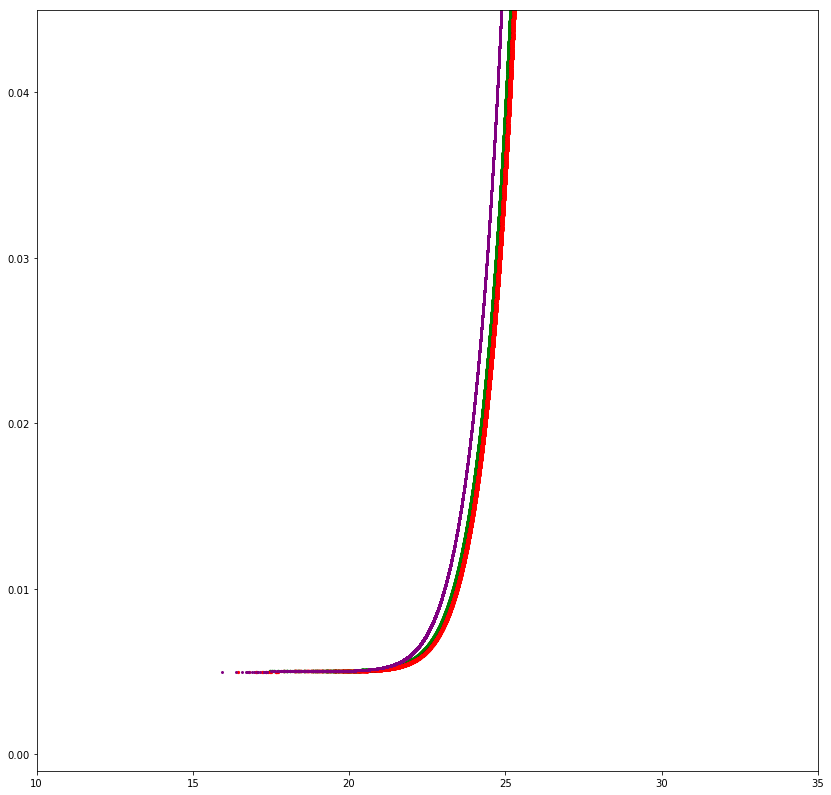

In [20]:
g = df['LSST_filters/magnitude:LSST_g:observed:dustAtlas']
fig = plt.figure(figsize=(14,14))
#plt.scatter(g[::100],df['scaterr_g'][::100],s=5,marker='.',c='b')
plt.scatter(df['scatmag_g'][::100],df['scaterr_g'][::100],s=25,marker='.',c='g')
plt.scatter(df['scatmag_r'][::100],df['scaterr_r'][::100],s=20,marker='.',c='r')
plt.scatter(df['scatmag_i'][::100],df['scaterr_i'][::100],s=15,marker='.',c='purple')
plt.xlim([10,35])
plt.ylim([-.001,.045])

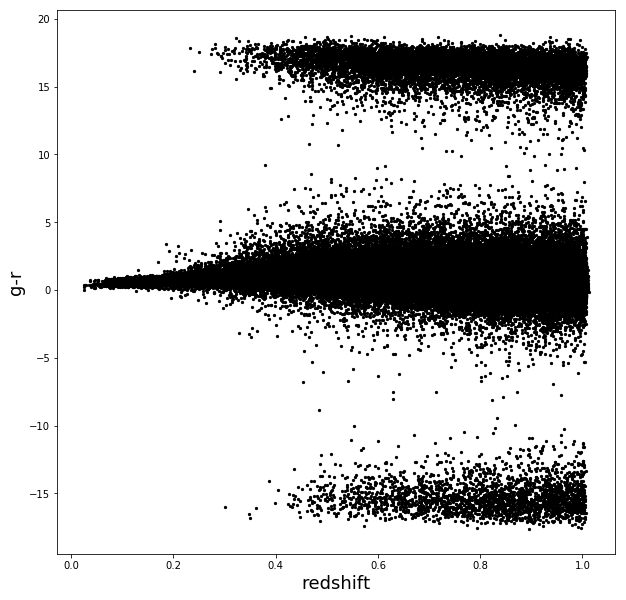

In [21]:
plt.scatter(df['redshift'][::100],df['scatmag_g'][::100]-df['scatmag_r'][::100],marker='o',s=5,
            c='k')
plt.xlabel("redshift",fontsize=18)
plt.ylabel("g-r",fontsize=18)

Make a couple color-color plots of the "truth" data before uncertainties have been added to the magnitudes

In [22]:
ug_t = utrue - gtrue
gr_t = gtrue - rtrue
ri_t = rtrue - itrue

In [23]:
mask = (itrue<25.3)
ug_tgold = ug_t[mask]
gr_tgold = gr_t[mask]
ri_tgold = ri_t[mask]

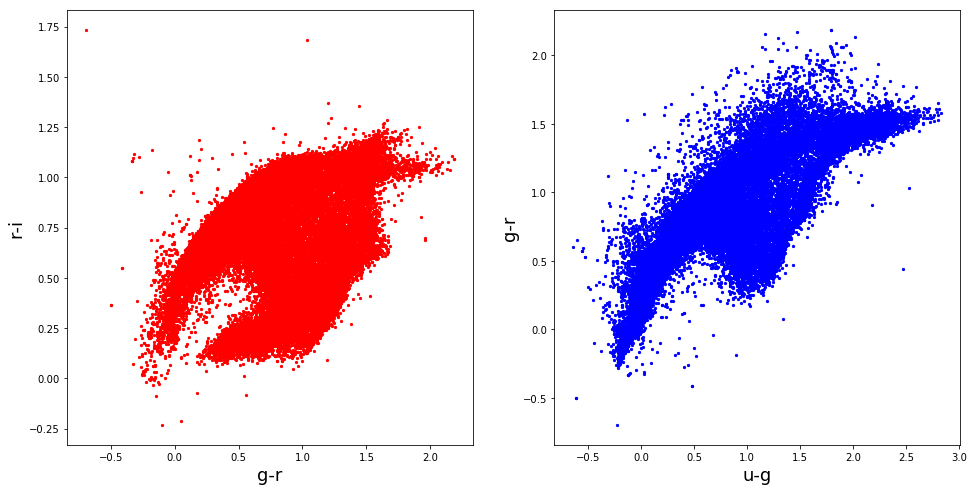

In [24]:
fig = plt.figure(figsize=(16,8))
ax=plt.subplot(121)
ax.scatter(gr_tgold[::100],ri_tgold[::100],marker='.',s=20,c='r')
plt.xlabel('g-r',fontsize=18)
plt.ylabel('r-i',fontsize=18)
bx = plt.subplot(122)
bx.scatter(ug_tgold[::100],gr_tgold[::100],marker='.',s=20,c='b')
plt.xlabel('u-g',fontsize=18)
plt.ylabel('g-r',fontsize=18)

Now write the pandas dataframe out to file, we'll write out to an hdf5 file

In [25]:
outfile_protodc2 = "protodc2_v5_ugrizy_witherrs.h5"
df.to_hdf(outfile_protodc2, 'df')